üìÇ Loading TIFF stack...
Loaded stack with shape: (2160, 1855, 1719)
üåÄ Removing ring artifacts...


Processing slices: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2160/2160 [07:51<00:00,  4.58it/s]


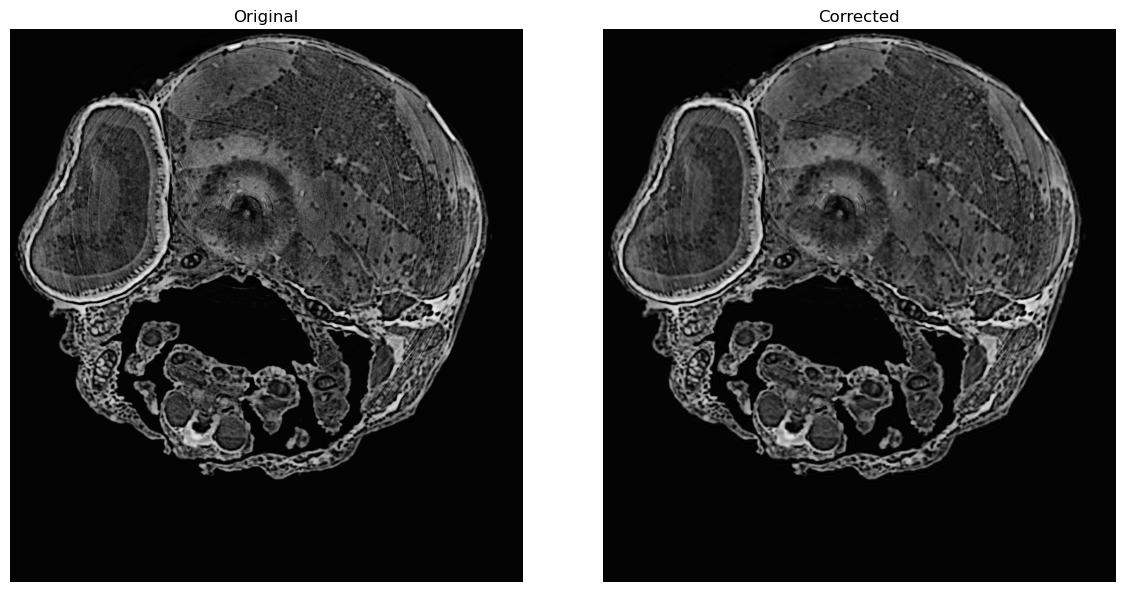

üíæ Saving corrected stack to: corrected_recon_025_AS1.6_4DPF_WB_18x(361nm).tiff


In [ ]:
import numpy as np
import pywt
import tifffile
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from tqdm import tqdm

# === CONFIGURATION ===
input_path = "recon_025_AS1.6_4DPF_WB_18x(361nm).tiff"  # or "your_file.tif"
output_path = "corrected_recon_025_AS1.6_4DPF_WB_18x(361nm).tiff"
wavelet = 'db5'
level = 3
threshold = 0.04

# === STEP 1: Load the TIFF stack ===
print("üìÇ Loading TIFF stack...")
stack = tifffile.imread(input_path).astype(np.float32)
stack /= np.max(stack)  # normalize to [0, 1]
print(f"Loaded stack with shape: {stack.shape}")

# === STEP 2: Define the artifact removal function ===
def remove_ring_wavelet_median(img, wavelet='db5', level=2, threshold=0.04):
    # Median filter
    img_med = median_filter(img, size=3)

    # Wavelet decomposition
    coeffs = pywt.wavedec2(img_med, wavelet=wavelet, level=level)
    cA, *details = coeffs
    new_details = []

    for d in details:
        if len(d) == 3:
            cH, cV, cD = d
            cH = pywt.threshold(cH, threshold * np.max(cH), mode='soft')
            cV = pywt.threshold(cV, threshold * np.max(cV), mode='soft')
            cD = pywt.threshold(cD, threshold * np.max(cD), mode='soft')
            new_details.append((cH, cV, cD))
        else:
            print("‚ö†Ô∏è Unexpected wavelet level format, skipping.")
            new_details.append(d)

    coeffs = [cA] + new_details
    return pywt.waverec2(coeffs, wavelet)

# === STEP 3: Apply to the whole stack ===
print("üåÄ Removing ring artifacts...")
corrected_stack = np.zeros_like(stack)

for i in tqdm(range(stack.shape[0]), desc="Processing slices"):
    try:
        corrected = remove_ring_wavelet_median(stack[i], wavelet, level, threshold)
        # Crop to original shape in case of edge effects
        corrected_stack[i] = corrected[:stack.shape[1], :stack.shape[2]]
    except Exception as e:
        print(f"‚ùå Error on slice {i}: {e}")
        corrected_stack[i] = stack[i]

# === STEP 4: Visualize one before/after slice ===
mid = stack.shape[0] // 2
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(stack[mid], cmap='gray', vmin=0, vmax=1)
plt.title("Original"); plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(corrected_stack[mid], cmap='gray', vmin=0, vmax=1)
plt.title("Corrected"); plt.axis('off')

plt.tight_layout()
plt.show()

# === STEP 5: Save corrected stack ===
print(f"üíæ Saving corrected stack to: {output_path}")
tifffile.imwrite(output_path, corrected_stack.astype(np.float32))
print("‚úÖ Done.")


In [4]:
import numpy as np
import pywt
import tifffile
from scipy.ndimage import median_filter
from tqdm import tqdm
import os

# === CONFIGURATION ===
input_path = "recon_025_AS1.6_4DPF_WB_18x(361nm).tiff"
output_path = "corrected-recon_025_AS1.6_4DPF_WB_18x(361nm)_stack.tiff"
wavelet = 'db5'
level = 2
threshold = 0.04

# === STEP 1: Load pages lazily ===
tiff = tifffile.TiffFile(input_path)
pages = tiff.pages
n_slices = len(pages)
print(f"üìÇ Found {n_slices} slices in {input_path}")

# Clear old output if exists
if os.path.exists(output_path):
    os.remove(output_path)

# === STEP 2: Define the artifact removal function ===
def remove_ring_wavelet_median(img, wavelet='db5', level=2, threshold=0.04):
    img = img.astype(np.float32)
    img /= np.max(img) if np.max(img) > 0 else 1

    img_med = median_filter(img, size=3)
    coeffs = pywt.wavedec2(img_med, wavelet=wavelet, level=level)
    cA, *details = coeffs
    new_details = []

    for d in details:
        if len(d) == 3:
            cH, cV, cD = d
            cH = pywt.threshold(cH, threshold * np.max(cH), mode='soft')
            cV = pywt.threshold(cV, threshold * np.max(cV), mode='soft')
            cD = pywt.threshold(cD, threshold * np.max(cD), mode='soft')
            new_details.append((cH, cV, cD))
        else:
            new_details.append(d)

    coeffs = [cA] + new_details
    return pywt.waverec2(coeffs, wavelet)[:img.shape[0], :img.shape[1]]

# === STEP 3: Process each slice and write ===
print("üßº Processing slices one by one...")

with tifffile.TiffWriter(output_path, bigtiff=True) as tif_out:
    for i in tqdm(range(n_slices), desc="Correcting slices"):
        try:
            raw = pages[i].asarray()
            cleaned = remove_ring_wavelet_median(raw)
            tif_out.write(cleaned.astype(np.float32))
        except Exception as e:
            print(f"‚ùå Slice {i} failed: {e}")
            tif_out.write(raw.astype(np.float32))  # fallback

print("‚úÖ Done. Output saved to:", output_path)


üìÇ Found 2160 slices in recon_025_AS1.6_4DPF_WB_18x(361nm).tiff
üßº Processing slices one by one...


Correcting slices: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2160/2160 [08:04<00:00,  4.46it/s]

‚úÖ Done. Output saved to: corrected-recon_025_AS1.6_4DPF_WB_18x(361nm)_stack.tiff


/home/minyu/miniconda3/envs/tomo-env/lib/python3.9/site-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


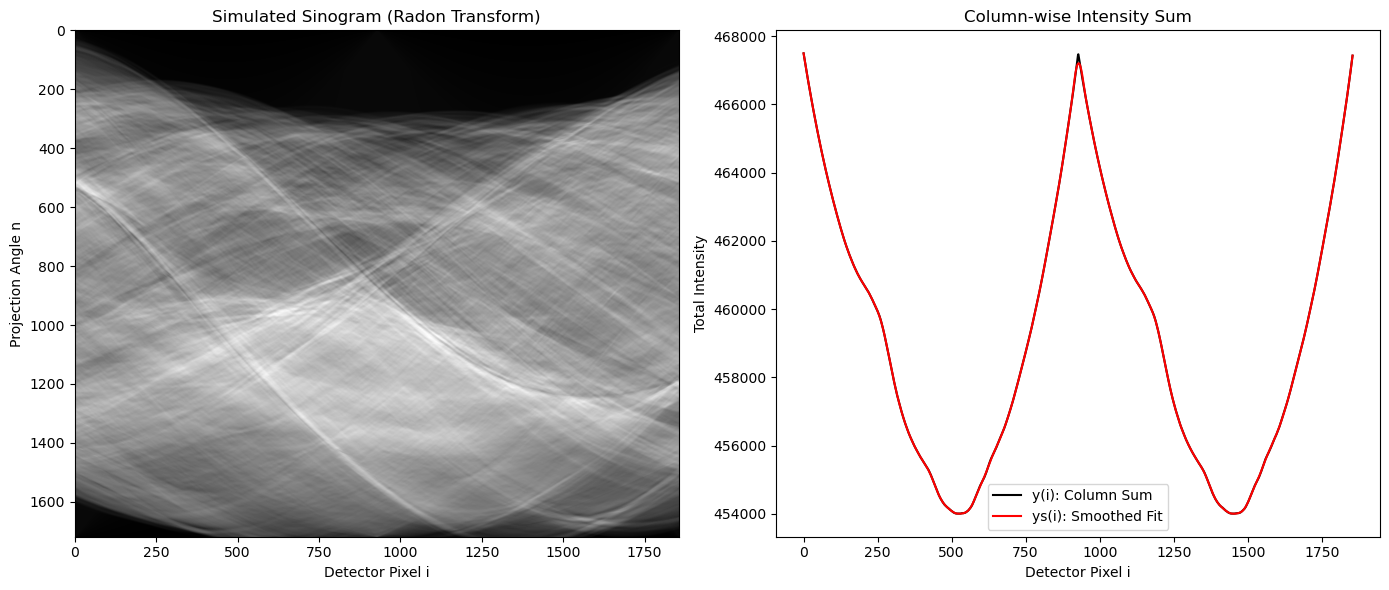

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon
import tifffile
from scipy.signal import savgol_filter

# === Load one representative slice ===
stack = tifffile.imread("recon_025_AS1.6_4DPF_WB_18x(361nm).tiff")
mid = stack.shape[0] // 2
slice_img = stack[mid].astype(np.float32)
slice_img /= np.max(slice_img)

# === Simulate sinogram via Radon transform ===
theta = np.linspace(0., 180., max(slice_img.shape), endpoint=False)
sinogram = radon(slice_img, theta=theta, circle=True)

# === Sum grey values per detector column (vertical lines) ===
y = np.sum(sinogram, axis=0)
y_smooth = savgol_filter(y, window_length=51, polyorder=3)

# === Plot everything ===
plt.figure(figsize=(14, 6))

# (A) Sinogram with vertical lines
plt.subplot(1, 2, 1)
plt.imshow(sinogram, cmap='gray', aspect='auto')
plt.title("Simulated Sinogram (Radon Transform)")
plt.xlabel("Detector Pixel i")
plt.ylabel("Projection Angle n")

# (B) 1D profile and smoothed fit
plt.subplot(1, 2, 2)
plt.plot(y, label='y(i): Column Sum', color='black')
plt.plot(y_smooth, label='ys(i): Smoothed Fit', color='red')
plt.title("Column-wise Intensity Sum")
plt.xlabel("Detector Pixel i")
plt.ylabel("Total Intensity")
plt.legend()

plt.tight_layout()
plt.show()


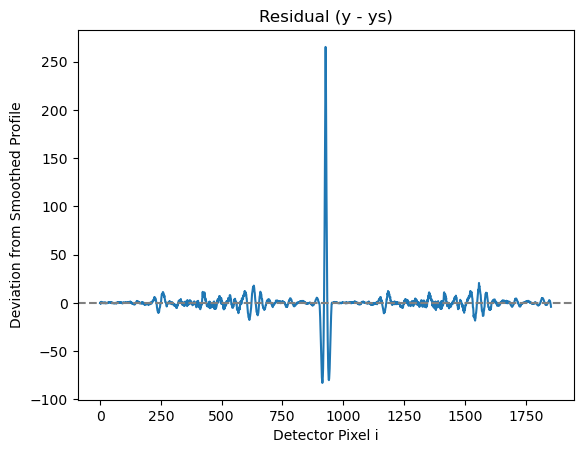

In [2]:
residual = y - y_smooth
plt.plot(residual)
plt.title("Residual (y - ys)")
plt.xlabel("Detector Pixel i")
plt.ylabel("Deviation from Smoothed Profile")
plt.axhline(0, linestyle='--', color='gray')
plt.show()


üîç Flagged detector bins (ring culprits): [909 910 911 912 913 914 915 916 917 918 923 924 925 926 927 928 929 930
 931 932 937 938 939 940 941 942 943 944 945 946]


/tmp/ipykernel_393/1916069259.py:58: UserWarning: Glyph 128420 (\N{BLACK HEART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_393/1916069259.py:58: UserWarning: Glyph 129293 (\N{WHITE HEART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_393/1916069259.py:58: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/minyu/miniconda3/envs/tomo-env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128420 (\N{BLACK HEART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/minyu/miniconda3/envs/tomo-env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129293 (\N{WHITE HEART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/minyu/miniconda3/envs/tomo-env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTIN

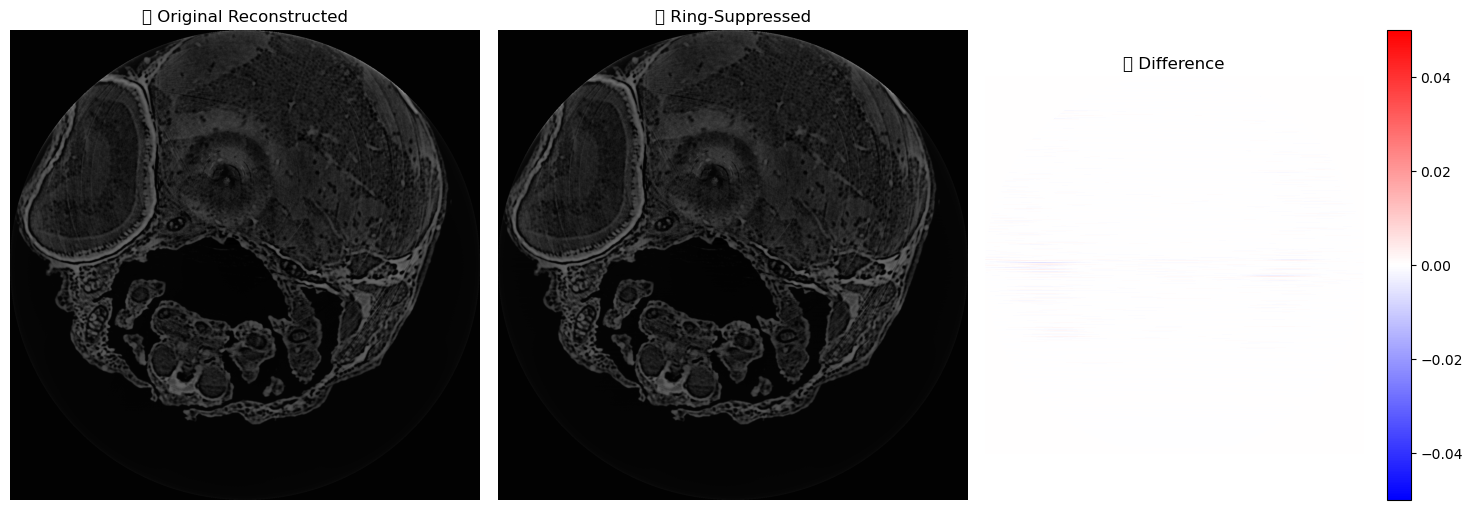

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from scipy.signal import savgol_filter
import tifffile

# === Load a single representative slice ===
stack = tifffile.imread("recon_025_AS1.6_4DPF_WB_18x(361nm).tiff")
mid = stack.shape[0] // 2
slice_img = stack[mid].astype(np.float32)
slice_img /= np.max(slice_img)

# === Step 1: Generate sinogram ===
theta = np.linspace(0., 180., max(slice_img.shape), endpoint=False)
sinogram = radon(slice_img, theta=theta, circle=True)

# === Step 2: Sum detector pixels and smooth ===
y = np.sum(sinogram, axis=0)
y_smooth = savgol_filter(y, window_length=51, polyorder=3)
residual = y - y_smooth

# === Step 3: Identify problematic bins ===
threshold = 50
ring_pixels = np.where(np.abs(residual) > threshold)[0]
print("üîç Flagged detector bins (ring culprits):", ring_pixels)

# === Step 4: Suppress these detector columns via interpolation ===
corrected_sinogram = sinogram.copy()

for i in ring_pixels:
    if 1 < i < sinogram.shape[1] - 2:
        # Replace with average of neighbors
        corrected_sinogram[:, i] = (sinogram[:, i-1] + sinogram[:, i+1]) / 2

# === Step 5: Reconstruct cleaned image (optional) ===
reconstructed_cleaned = iradon(corrected_sinogram, theta=theta, circle=True)
reconstructed_original = iradon(sinogram, theta=theta, circle=True)

# === Step 6: Plot comparison ===
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(reconstructed_original, cmap='gray')
plt.title("üñ§ Original Reconstructed")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(reconstructed_cleaned, cmap='gray')
plt.title("ü§ç Ring-Suppressed")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_original - reconstructed_cleaned, cmap='bwr', vmin=-0.05, vmax=0.05)
plt.title("üîç Difference")
plt.axis('off')
plt.colorbar()

plt.tight_layout()
plt.show()


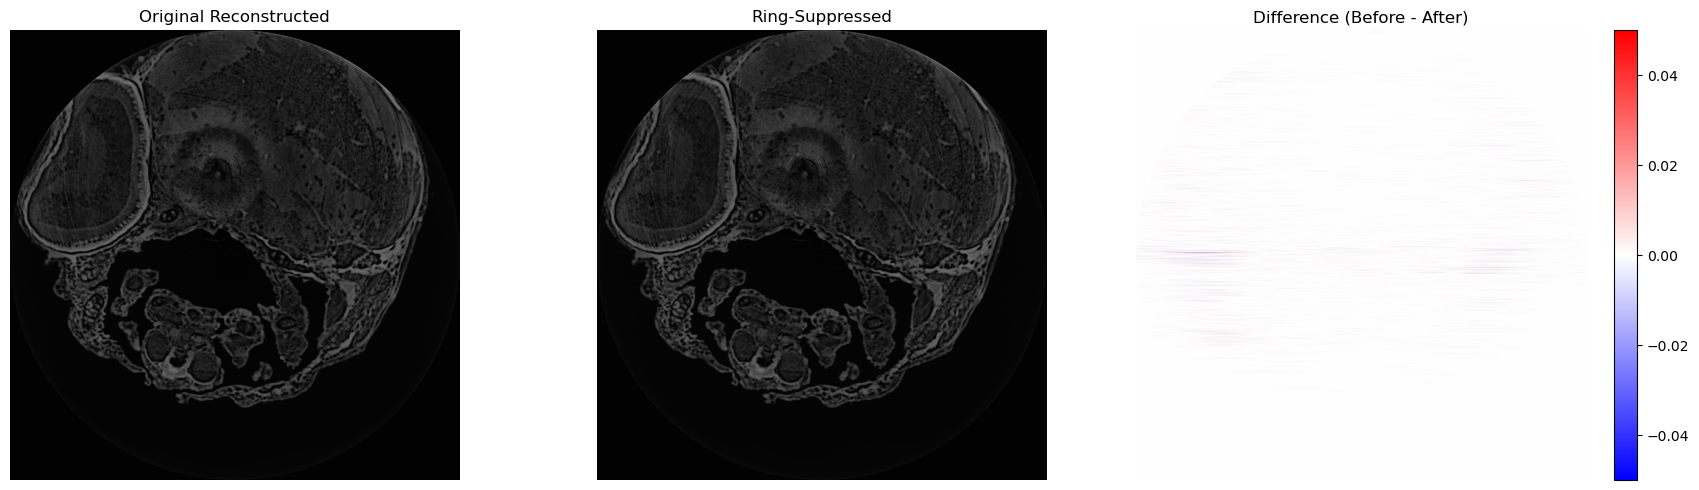

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from scipy.signal import savgol_filter
import tifffile

# === Load one slice ===
stack = tifffile.imread("recon_025_AS1.6_4DPF_WB_18x(361nm).tiff")
mid = stack.shape[0] // 2
slice_img = stack[mid].astype(np.float32)
slice_img /= np.max(slice_img)

# === Generate sinogram ===
theta = np.linspace(0., 180., max(slice_img.shape), endpoint=False)
sinogram = radon(slice_img, theta=theta, circle=True)

# === Flagged bad bins manually ===
bad_bins = np.array([
    909, 910, 911, 912, 913, 914, 915, 916, 917, 918,
    923, 924, 925, 926, 927, 928, 929, 930, 931, 932,
    937, 938, 939, 940, 941, 942, 943, 944, 945, 946
])

# === Interpolate these bins ===
corrected_sinogram = sinogram.copy()
for i in bad_bins:
    if 2 < i < sinogram.shape[1] - 3:
        # Smarter: average of left/right and also diagonals
        corrected_sinogram[:, i] = (
            0.25 * sinogram[:, i-2] +
            0.5  * sinogram[:, i-1] +
            0.5  * sinogram[:, i+1] +
            0.25 * sinogram[:, i+2]
        ) / 1.5

# === Reconstruct images ===
recon_original = iradon(sinogram, theta=theta, circle=True)
recon_cleaned  = iradon(corrected_sinogram, theta=theta, circle=True)

# === Plot results ===
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.imshow(recon_original, cmap='gray')
plt.title("Original Reconstructed")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(recon_cleaned, cmap='gray')
plt.title("Ring-Suppressed")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(recon_original - recon_cleaned, cmap='bwr', vmin=-0.05, vmax=0.05)
plt.title("Difference (Before - After)")
plt.axis('off')
plt.colorbar()

plt.tight_layout()
plt.show()


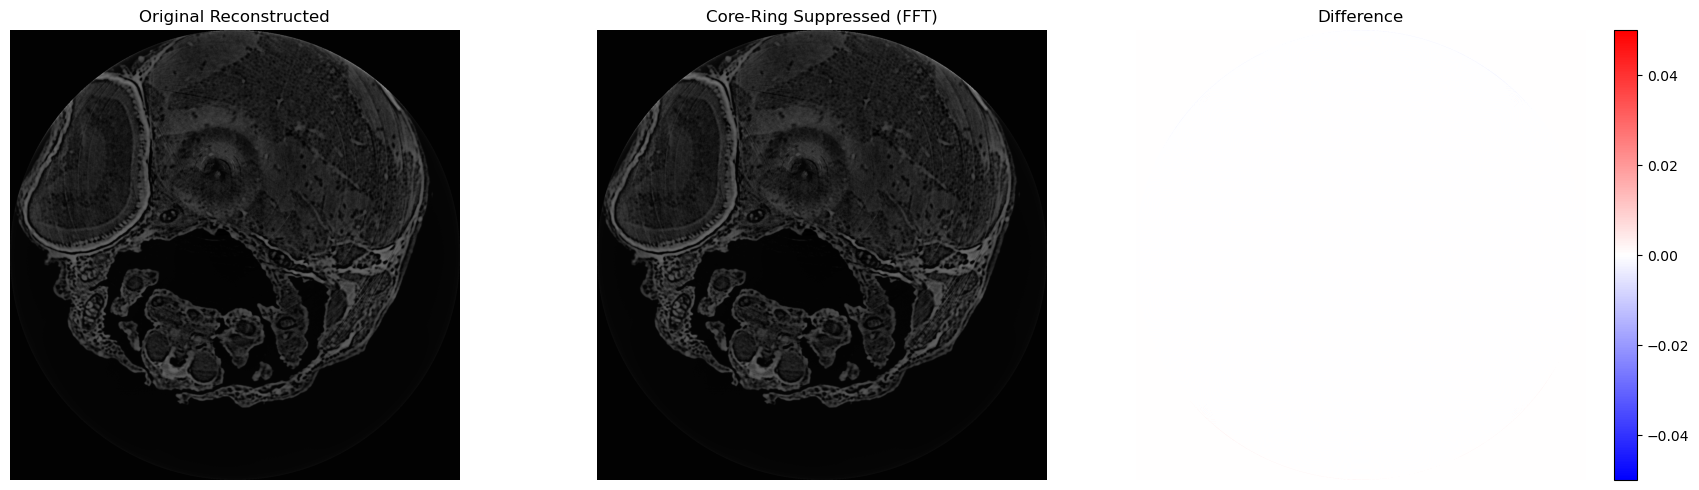

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from scipy.fft import fft, ifft, fftshift, ifftshift
from scipy.signal import butter, filtfilt
import tifffile

# === Load one slice ===
stack = tifffile.imread("recon_025_AS1.6_4DPF_WB_18x(361nm).tiff")
mid = stack.shape[0] // 2
slice_img = stack[mid].astype(np.float32)
slice_img /= np.max(slice_img)

# === Simulate sinogram ===
theta = np.linspace(0., 180., max(slice_img.shape), endpoint=False)
sinogram = radon(slice_img, theta=theta, circle=True)

# === Apply vertical FFT notch filter (high-pass on each detector column) ===
def highpass_filter(signal, cutoff=0.005):
    # Apply FFT along the vertical axis (each detector pixel)
    fft_sino = fftshift(fft(signal, axis=0), axes=0)
    n = fft_sino.shape[0]
    freqs = np.fft.fftfreq(n).reshape(-1, 1)

    # Create high-pass mask (zero out low freq)
    mask = np.abs(freqs) > cutoff
    fft_sino_filtered = fft_sino * mask

    # Inverse FFT
    filtered = np.real(ifft(ifftshift(fft_sino_filtered, axes=0), axis=0))
    return filtered

corrected_sinogram = highpass_filter(sinogram, cutoff=0.005)

# === Reconstruct cleaned image ===
recon_original = iradon(sinogram, theta=theta, circle=True)
recon_filtered = iradon(corrected_sinogram, theta=theta, circle=True)

# === Compare ===
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.imshow(recon_original, cmap='gray')
plt.title("Original Reconstructed")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(recon_filtered, cmap='gray')
plt.title("Core-Ring Suppressed (FFT)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(recon_original - recon_filtered, cmap='bwr', vmin=-0.05, vmax=0.05)
plt.title("Difference")
plt.axis('off')
plt.colorbar()

plt.tight_layout()
plt.show()
